# PART 1. Preprocessing

# Table of Contents
1. [Mount Google Drive](#s1)
2. [Import Libraries](#s2)
3. [Load Data](#s3)
4. [Text Preprocessing](#s4)
* 4.1. [Drop columns](#s4-1)
* 4.2. [Sentiment distribution](#s4-2)
* 4.3. [Remove usernames and HTML tags](#s4-3)
* 4.4. [Case folding](#s4-4)
* 4.5. [Remove HTML escape tags](#s4-5)
* 4.6. [Remove emoticons](#s4-6)
* 4.7. [Replace contractions](#s4-7)
* 4.8. [Replace all punctuations but hashtags](#s4-8)
* 4.9. [Remove consequitive white spaces](#s4-9)
* 4.10. [Hashtag preprocessing](#s4-10)
* 4.11. [Fix for duplicate consequitive letters >2](#s4-11)
* 4.12. [Replace chat words](#s4-12)
* 4.13. [Drop rows with empty tweets](#s4-13)
5. [Tokenization](#s5)
* 5.1. [Replace user exclaimed texts with their meaning](#s5-1)
* 5.2. [Stopwords removal](#s5-2)
* 5.3. [Lemmatization](#s5-3)
* 5.4. [Numbers removal](#s5-4)
* 5.5. [Removing empty tokens](#s5-5)
* 5.6. [Long words preprocessing](#s5-6)







## <a name="s1">1. Mount Google Drive</a>



In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!ls "/content/drive/MyDrive/INM427_NC_Coursework"

BERT.ipynb		   __pycache__
CNN.ipynb		   records_bilstm_1.csv
data			   records_bilstm_2.csv
GloVe			   records_bilstm_3.csv
hashtag_dict.txt	   records_cnn_1.csv
lookup.csv		   records_preds.csv
lookup_tokens.txt	   sentiment140-small.csv
output			   tensorboard_dir
PART1_PreProcessing.ipynb  train_data.csv
PART2_BiLSTM.ipynb	   twitter-sentiment-analysis-eda-part-2.ipynb


In [3]:
path_dir = '/content/drive/MyDrive/INM427_NC_Coursework/'

In [4]:
!pip install wordsegment

     |████████████████████████████████| 4.8 MB 20.6 MB/s 


## <a name="s2">2. Import libraries</a>
<!-- ##  <a class="anchor" id="s1"></a> -->


In [5]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import random

import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist

from collections import Counter
from wordsegment import load, segment

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

from torch.utils import data


SEED = 42
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

## <a name="s3">3. Load Data</a>

The dataset being used is the **<a href='http://help.sentiment140.com/for-students/'>sentiment140 dataset</a>**. It contains 1,600,000 tweets extracted using the **Twitter API**. The tweets have been annotated **(0 = Negative, 4 = Positive)**. We will generate training, validation and test set fromthis file alone. 

In [6]:
twitter_dataset = pd.read_csv(path_dir + 'data/training.1600000.processed.noemoticon.csv', 
                              encoding='ISO-8859-1' , names=['labels', 'ids', 'date', 'query', 'user_names', 'tweets'])
twitter_dataset.dropna(inplace=True)

The data is a CSV with emoticons removed. Data file format has 6 fields:
- the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
- the id of the tweet (2087)
- the date of the tweet (Sat May 16 23:58:44 UTC 2009)
- the query (lyx). If there is no query, then this value is NO_QUERY.
- the user that tweeted (robotickilldozr)
- the text of the tweet (Lyx is cool)

In [7]:
twitter_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   labels      1600000 non-null  int64 
 1   ids         1600000 non-null  int64 
 2   date        1600000 non-null  object
 3   query       1600000 non-null  object
 4   user_names  1600000 non-null  object
 5   tweets      1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 85.4+ MB


## <a name="s4">4. Text Preprocessing</a>



### <a name="s4-1">4.1. Drop columns</a>

In [8]:
# Drop unnesessary columns
twitter_dataset = twitter_dataset[['labels', 'tweets']]
twitter_dataset.head()

,labels,tweets
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [9]:
# We have 0 for negative, 4 for positive labels
twitter_dataset.labels.unique()

array([0, 4])

In [10]:
# replace sentiment label for positive to 1, keeping negative as 0
twitter_dataset.labels = twitter_dataset.labels.replace(4, 1)

### <a name="s4-2">4.2. Sentiment Distribution</a>

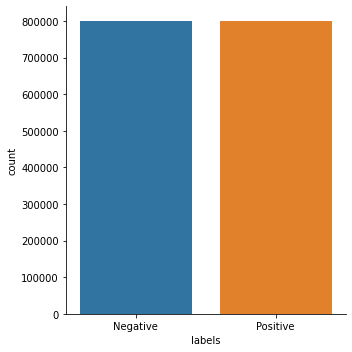

In [11]:
# visual analysis of the distribution of the sentiment data
t_plot = sns.catplot(data=twitter_dataset, x="labels", kind='count')
t_plot.set_xticklabels(["Negative", "Positive"])

In [12]:
# We have no data imbalance
twitter_dataset.labels.value_counts()

0    800000
1    800000
Name: labels, dtype: int64

### <a name="s4-3">4.3. Remove usernames and html tags</a>

In [13]:
# defining object for twitter regex
urlPattern1 = "((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)" # pattern to remove urls starting with http and www in string
urlPattern2 = r'[\S]+\.(net|com|org|info|edu|gov|uk|de|ca|jp|fr|au|us|ru|ch|it|nel|se|no|es|mil)[\S]*\s?' # regex to remove urls and domain names in string 
userPattern = '@[^\s]+' # pattern to remove usernames starting with @

# apply regex to tweets
twitter_dataset['tweets'] = [re.sub(urlPattern1, '', s) for s in twitter_dataset.tweets] # remove urls starting with protocols 
twitter_dataset['tweets'] = [re.sub(urlPattern2, '', s) for s in twitter_dataset.tweets] # remove urls ending with domain names
twitter_dataset['tweets'] = [re.sub(userPattern, '', s) for s in twitter_dataset.tweets] # remove usernames @

### <a name="s4-4">4.4. Case folding</a>

In [14]:
# apply lower case to all tweets
twitter_dataset.tweets = twitter_dataset.tweets.apply(lambda x: str(x).lower())
twitter_dataset.head()

,labels,tweets
0,0,"- awww, that's a bummer. you shoulda got david carr of third day to do it. ;d"
1,0,is upset that he can't update his facebook by texting it... and might cry as a result school today also. blah!
2,0,i dived many times for the ball. managed to save 50% the rest go out of bounds
3,0,my whole body feels itchy and like its on fire
4,0,"no, it's not behaving at all. i'm mad. why am i here? because i can't see you all over there."


In [15]:
# shuffle the dataset
twitter_dataset = twitter_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

### <a name="s4-5">4.5. Remove HTML escape tags</a>

In [16]:
html_escape_list = ("&amp;","&quot;","&apos;","&gt;","&lt;")

for tag in html_escape_list: 
    twitter_dataset['tweets'] = twitter_dataset['tweets'].str.replace(tag, ' ')

### <a name="s4-6">4.6. Replace emoticons</a>

In [17]:
%%time
# defining dictionary object for emoticons - manually compiled list
emoticons = { ':)': 'smile', ':-)': 'smile', ';d': 'wink', ':d': 'grin', 
              ':-e': 'vampire', ':(': 'sad', ':-|': 'indifferent', ':<': 'pout',
              ':-(': 'sad', ':-<': 'sad', ':p': 'teasing', ';p': 'teasing',
              ':o': 'surprised', ':-o': 'bored', ":'(": 'sad', ':-&': 'sick', 
              '-_-': 'whatever', ':0': 'yummy', ':o': 'hungry', 
              ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', 
              ':\\': 'annoyed', ':/': 'unsure', ':c': 'sad', ':-w': 'waiting',
              ':#': 'mute', ':x': 'mute', ':^)': 'smile', ':-&': 'confused', 
              '$_$': 'greedy', '>.<': 'sour', ';^)': 'smirking', '(:': 'happy',
              '@@': 'eyeroll', ':-!': 'confused', ':-d': 'grin', ':-0': 'yell', 
              'o.o': 'confused', '^_^': 'overjoyed', '>:3': 'evil cuteness',
              '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sad smile', 
              ';)': 'wink', '>:)': 'evil grin', '~_~': 'sleepy',':<)': 'snobby', 
              ';-)': 'wink', 'o:-)': 'angel','o*-)': 'angel','(:-d': 'gossip',
              '=^.^=': 'cat', '@_@': 'mesmerized', '^^': 'embarrassed',
              ':-|': 'straight face', ':-o>': 'yuck face', 'xd': 'hyper',
              ':>': 'smug', '.-)': 'wink', '>w<': 'worried', ':t': 'doubtful',
              'd:': 'scared', ':-1': 'smirk', '>:(': 'angry', ':@': 'angry',
              '>.<': 'upset', 'n_n': 'cute', ';@': 'angry', ':-9': 'yummy',
              ':-/': 'perplexed', '-.-': 'stressed', ':-((': 'very sad',
              ':((': 'very sad', "':-)": 'sweating', '>:D': 'evil laugh',
              ':s': 'confused', ':l': 'laugh', ':}': 'smile', ':-*': 'kiss',
              '(:': 'sad', ':$': 'greedy', ':-x': 'mute', ':-p': 'teasing',
              ':-j': 'smile', ':j':'smile',  ":')": 'sad smile', '(:': 'sad', 
              ':]': 'smile', ':[': 'sad', ':-s': 'confused', ")':": 'sad smile',
              ':*': 'kiss', ':-\\': 'annoyed', ':-?': 'confused', ';-d': 'grin',
              ":'-(": 'tearful', ';-o': 'surprised', ':|': 'straight face',
            }

for key, value in emoticons.items():
    twitter_dataset['tweets'] = [re.sub(re.escape(key), value, s) for s in twitter_dataset['tweets']]

CPU times: user 6min 39s, sys: 1.45 s, total: 6min 40s
Wall time: 6min 42s


### <a name="s4-7">4.7. Replace contractions</a>

In [18]:
contractions = pd.read_csv(path_dir + '/data/contractions.csv')
contractions = contractions.apply(lambda x: x.astype(str).str.lower())
contractions_dict = dict(zip(contractions.Contraction, contractions.Meaning))

def fix_meaning(val):   
    for x in val.split(): 
        if x in contractions_dict.keys(): 
            val = val.replace(x, contractions_dict[x]) 
    return val

twitter_dataset['tweets'] = twitter_dataset['tweets'].apply(lambda x: fix_meaning(x))
twitter_dataset.head()

,labels,tweets
0,0,ahhh i hope you are ok!!!
1,0,"cool , i have no tweet apps for my razr 2"
2,0,"i know just family drama. it is lame.hey next time u hang out with kim n u guys like have a sleepover or whatever, ill call u"
3,0,school email will not open and i have geography stuff on there to revise! *stupid school* sad
4,0,upper airways problem


### <a name="s4-8">4.8. Replace all punctutaions but hashtags</a>

We will replace all the punctuations with white spaces but hashtags, since we will preprocess the hashtags in the next sections.

In [19]:
# punctPattern = r"[%'/+<=>,.;:@^_`{|}~?!&$*]+\*"
my_punct = ['!', '"', '$', '%', '&', "'", '(', ')', '*', '+', ',', '.',
           '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', 
           '`', '{', '|', '}', '~', '»', '«', '“', '”']
punctPattern = re.compile("[" + re.escape("".join(my_punct)) + "]")
twitter_dataset['tweets'] = [re.sub(punctPattern, ' ', s) for s in twitter_dataset['tweets']]
twitter_dataset.head()

,labels,tweets
0,0,ahhh i hope you are ok
1,0,cool i have no tweet apps for my razr 2
2,0,i know just family drama it is lame hey next time u hang out with kim n u guys like have a sleepover or whatever ill call u
3,0,school email will not open and i have geography stuff on there to revise stupid school sad
4,0,upper airways problem


### <a name="s4-9">4.9. Remove consequitive white spaces</a>

We will remove consequitive white spaces with single space

In [20]:
twitter_dataset['tweets'] = [re.sub('[\s]+', ' ', s) for s in twitter_dataset['tweets']]

### <a name="s4-10">4.10. Hashtags preprocessing</a>

Add space between hashtags

If there are consequtive hashtags followed by one another, insert white space in between in order to seperate them.

In [21]:
hashPattern = r'\b[#:]\b' # regex pattern
twitter_dataset['tweets'] = [re.sub(hashPattern, ' #', s) for s in twitter_dataset.tweets]

#### 4.10.1. Filter out Hashtags

In [22]:
df_hashtags = twitter_dataset.copy()
df_hashtags['hashtags'] = df_hashtags['tweets'].str.findall(r'#.*?(?=\s|$)')
df_hashtags = df_hashtags[df_hashtags['hashtags'].map(lambda d: len(d)) > 0]
df_hashtags

,labels,tweets,hashtags
57,1,it means the same to us #gocats,[#gocats]
128,0,#iranelection the yellow press is alive and well in the 21st century how quickly we forget the uss maine,[#iranelection]
149,1,enjoying the morning just hanging out with juliet in victoria she does not know it yet but i am taking her to see il divo tonight #fb,[#fb]
195,1,thank you everyone i seriously am i lucky guy to have such great and lovely friends let us keep in touch at #lax,[#lax]
209,1,lots of cool ppl #followfriday,[#followfriday]
...,...,...,...
1599848,0,has to go out again tonight #,[#]
1599872,1,big shout out to fox hollow coffee in elkton md - they made it easier for me to stay awake overnight for #relayforlife - thanks guys,[#relayforlife]
1599895,0,ne mit compat10 aber auch das tuts nicht #upgrade-hell #symfony,"[#upgrade-hell, #symfony]"
1599921,1,ahhh 1 week until my birthday june 21st ya ll remember expensive gifts only it s the amount that counts hi 5ive #fb,[#fb]


#### 4.10.2. Function for fixing consequetive hashtag words

In [23]:
# adapted from https://laurendahlin.github.io/colleges_on_social_media/Html/04_tweet_processing
# The following function will clean the hashtags, removing hashes and numbers, as well as segmenting out individual words.
# Hash fix - will be called from within tweet cleaning function
load()
def hash_fix(h):
    h1 = re.sub(r'#', '', h)
    h2 = segment(str(h1))
    h3 = ' '.join(map(str, h2)) 
    return h3

# Create a dictionary that contains each hash tag and the text it should be replaced with.
# Inputs: dataframe with the tweets and the column with the hashtags
def hash_dict(df,hash_col):
    # Create a datafame of all hashtags in a column and their counts
    # Note: hashtags are in lists inside a cell e.g. [#hash1, #hash2] 
    tag_counts = df[hash_col].apply(pd.Series).stack().value_counts().to_frame()
    tag_counts = tag_counts.reset_index()
    tag_counts.columns = ['hash','freq']
    # Remove numbers and segment multiple words using hash fix
    tag_counts = tag_counts.assign(clean_tag = tag_counts.hash.apply(lambda x: hash_fix(x)))
    # Create a dictionary of the hashtags and their clean strings
    tag_counts.set_index('hash', inplace=True)
    tag_dict = tag_counts['clean_tag'].to_dict()
    return tag_dict

In [24]:
hashtag_dict = hash_dict(df_hashtags,'hashtags')

In [25]:
hashtag_dict

{'#followfriday': 'follow friday',
 '#fb': 'fb',
 '#ff': 'ff',
 '#': '',
 '#squarespace': 'squarespace',
 '#1': '1',
 '#iranelection': 'iran election',
 '#seb-day': 'seb day',
 '#musicmonday': 'music monday',
 '#fail': 'fail',
 '#2': '2',
 '#asot400': 'asot400',
 '#iphone': 'i phone',
 '#bsb': 'bsb',
 '#iremember': 'i remember',
 '#myweakness': 'my weakness',
 '#marsiscoming': 'mars is coming',
 '#f1': 'f1',
 '#e3': 'e3',
 '#bgt': 'bgt',
 '#mcflyforgermany': 'mcfly for germany',
 '#andyhurleyday': 'andy hurley day',
 '#inaperfectworld': 'in a perfect world',
 '#haveyouever': 'have you ever',
 '#spymaster': 'spymaster',
 '#delongeday': 'delonge day',
 '#trackle': 'track le',
 '#shaunjumpnow': 'shaun jump now',
 '#tcot': 't cot',
 '#mileymonday': 'miley monday',
 '#goodsex': 'good sex',
 '#3': '3',
 '#twitter': 'twitter',
 '#chuckmemondays': 'chuck me mondays',
 '#xboxe3': 'xboxe3',
 '#bradiewebb': 'brad ie webb',
 '#hhrs': 'h hrs',
 '#dontyouhate': 'dont you hate',
 '#mmwanted': 'mm wan

In [26]:
with open(path_dir + 'output/hashtag_dict.txt', 'w') as f:
    f.write(str(hashtag_dict))

#### 4.10.3 Hashtag Converstion
Here we use generated hashtag dictionary to convert and split hashtags to text

In [27]:
def hashtag_conversion(text):
    new_text = []
    for w in text.split():
        if w in hashtag_dict.keys():
            new_text.append(hashtag_dict[w])
        else:
            new_text.append(w)
    return " ".join(new_text)

df_hashtags['tweets'] = df_hashtags['tweets'].apply(lambda x: hashtag_conversion(x))

#### 4.10.4. Update the tweets column with modified hashtags

In [28]:
df1 = df_hashtags.copy()
df1.drop(columns='hashtags', inplace=True)
df2 = twitter_dataset.copy()
df1 = df1.reset_index(drop=False)
df2 = df2.reset_index(drop=False)
df_twitter = df2.merge(df1, on='index', how='left')
df_twitter.tweets_y.fillna(df_twitter.tweets_x, inplace=True)
df_twitter.drop(columns=['index', 'labels_y', 'tweets_x'], inplace=True)
df_twitter.rename(columns={'labels_x': 'labels', 'tweets_y': 'tweets'}, inplace=True)
df_twitter.to_csv('lookup.csv')

Apply final regex to the dataframe (keeping alphanumerical characters and spaces)

In [29]:
df_twitter['tweets'] = [re.sub(r'[^a-zA-Z0-9 ]', '', s) for s in df_twitter['tweets']] # keep only alphanumerical characters and (single) white spaces

### <a name="s4-11">4.11. Fix for duplicate consequitive letters >2</a>

Word lengthening occurs when characters are wrongly repeated. English words have a max of two repeated characters. Additional characters need to ripped off, otherwise we might add misleading information. I have written a function for this purpose, which rip offs repeated characters more than 2.

- https://rustyonrampage.github.io/text-mining/2017/11/28/spelling-correction-with-python-and-nltk.html

In [30]:
def reduce_lengthening(text):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)

df_twitter['tweets'] = df_twitter['tweets'].apply(lambda x: reduce_lengthening(x))

### <a name="s4-12">4.12. Replace chat words</a>

In [31]:
# chat words and their meanings (manually compiled)
chat_words_str = """
TGIF=Thank god it is friday
TMR=Tomorrow
NKOTB=new kid on the block
tmi=too much information
yknow=you know
gnite=good night
nite=night
c=see
ol=old
r=are
de=the
da=the
th=the
u=you
n=and
pct=percent
pc=personal computer
nyc=new york city
def=definetaly
rd=real deal
dm=direct message
yr=year
mn=month
hr=hour
sec=second
pm=private message
bout=about
smh=shake my head
tellem=tell them
msging=messaging
txting=texting
atpm=about to pee myself
tonite=tonight
2NITE=Tonight
2MORO=Tomorrow
GTG=Got to Go
GTD=Got to Do
LIL=Little
SML=Small
LRG=Large
LG=Large
IMMA=I am going to
IMA=I am going to
LUV=Love
BRO=Brother
SIS=Sister
SI=Siter
MAA=Mother
MA=My
PLZ=Please
OMG=Oh My God
OMFG=Oh My Fucking God
SNAFU=Situation Normal All Fucked Up
SMH=Shaking My Head
MSG=Message
FU=Fuck You
AFAIK=As Far As I Know
AFK=Away From Keyboard
ASAP=As Soon As Possible
ATK=At The Keyboard
ATM=At The Moment
A3=Anytime, Anywhere, Anyplace
BAK=Back
BBL=Be Back Later
BBS=Be Back Soon
BFN=Bye For Now
B4N=Bye For Now
BRB=Be Right Back
BRT=Be Right There
BTW=By The Way
B4=Before
B4N=Bye For Now
CU=See You
CUL8R=See You Later
CYA=See You
FAQ=Frequently Asked Questions
FC=Fingers Crossed
FWIW=For What It's Worth
FYI=For Your Information
GG=Good Game
GN=Good Night
GMTA=Great Minds Think Alike
GR8=Great
G9=Genius
IC=I See
ICQ=I Seek you
ILU=ILU: I Love You
IMHO=In My Honest/Humble Opinion
IMO=In My Opinion
IOW=In Other Words
IRL=In Real Life
LDR=Long Distance Relationship
LMAO=Laugh My A.. Off
LOL=Laughing Out Loud
LTNS=Long Time No See
L8R=Later
MTE=My Thoughts Exactly
M8=Mate
NRN=No Reply Necessary
OIC=Oh I See
PITA=Pain In The Ass
PRT=Part
PRW=Parents Are Watching
ROFL=Rolling On The Floor Laughing
ROTFL=Rolling On The Floor Laughing
ROFLOL=Rolling On The Floor Laughing Out Loud
ROTFLMAO=Rolling On The Floor Laughing My A.. Off
SK8=Skate
ASL=Age, Sex, Location
THX=Thank You
TTFN=Ta-Ta For Now!
TTYL=Talk To You Later
U=You
U2=You Too
U4E=Yours For Ever
WB=Welcome Back
WTF=What The Fuck
WTG=Way To Go
WUF=Where Are You From
W8=Wait
EM=Them
W=With
WO=Without
"""
chat_words_map_dict = {}
for line in chat_words_str.split("\n"):
    if line != "":
        cw = (line.split("=")[0]).lower()
        cw_expanded = (line.split("=")[1]).lower()
        chat_words_map_dict[cw] = str(cw_expanded)

def chat_words_conversion(text):
    new_text = []
    for w in text.split():
        if w in chat_words_map_dict.keys():
            new_text.append(chat_words_map_dict[w])
        else:
            new_text.append(w)
    return " ".join(new_text)

df_twitter['tweets'] = df_twitter['tweets'].apply(lambda x: chat_words_conversion(x))

In [32]:
df_twitter['tweets'] = [re.sub(r'[^a-z ]+', '', s) for s in df_twitter['tweets']] # keep alphabetic characters and space
df_twitter['tweets'] = [re.sub('\d+','', s) for s in df_twitter['tweets']] # remove digits

### <a name="s4-13">4.13. Drop rows with empty tweets</a>

After preprocessing some rows returns empty tweets, which needs to be removed from the dataset

In [33]:
df_twitter['tweets'].replace('', np.nan, inplace=True)
df_twitter.dropna(subset=['tweets'], inplace=True)
df_twitter.reset_index(drop=True, inplace=True)
df_twitter.shape

(1596180, 2)

**Checkpoint 1**

In [34]:
df_twitter.to_csv(path_dir + 'output/checkpoints/twitter_df_checkpoint_1.csv', index=False, header=False)
df_twitter = pd.read_csv(path_dir + 'output/checkpoints/twitter_df_checkpoint_1.csv', names=['labels', 'tweets'])

## <a name="s5">5. Tokenization</a>

In [35]:
%%time
tknzr = TweetTokenizer()

tweets = df_twitter['tweets'].tolist()
sentiments = df_twitter['labels'].tolist()

reviews = [tknzr.tokenize(s) for s in tweets]

CPU times: user 55.4 s, sys: 1.97 s, total: 57.4 s
Wall time: 57.4 s


### <a name="s5-1">5.1. Replace user exclaimed texts with their meaning</a>
Note: This cell will take quite bit of time to run...

In [36]:
%%time
# all regex were compiled manually using https://regex101.com/
for token in reviews:
  for i in range(len(token)):
    token[i] = re.sub(r'^a+h+$','ahh',token[i]) #handle aahh aah ah 
    token[i] = re.sub(r'^([ha]+)+h*a*i*$','laugh',token[i]) #handle ahhahhaa
    token[i] = re.sub(r'^[z]+$','sleepy',token[i]) #handle zz
    token[i] = re.sub(r'^(l+o+l+)+l*o*$','laugh',token[i]) #handle lolol lollol looolllloool
    token[i] = re.sub(r'^(s+o+)+$','so',token[i]) #handle ssoo soso
    token[i] = re.sub(r'^(n+o+)+$','no',token[i]) #handle nnoo nono
    token[i] = re.sub(r'^(t+oo+)+$','too',token[i]) #handle tootoo tttoo
    token[i] = re.sub(r'^(y+[ea]+s*h*)+$','yes',token[i]) #handle yyeesshh yesyes yeah yaa
    token[i] = re.sub(r'^(b+l+a+h*)+$','blah',token[i]) #handle bbllaahh blahblahhh
    token[i] = re.sub(r'^(n+i+c+e+)+$','nice',token[i]) #handle nicenice nniiccee
    token[i] = re.sub(r'^(s+t+[ou]*p+i+d+)+$','stupid',token[i]) #handle sttuuppiidd stooopppiiidd
    token[i] = re.sub(r'^(n+o*t+)+$','not',token[i]) #handle nnoooottt notnot nt
    token[i] = re.sub(r'^(t+e+r+i+b+l+e+)+$','terrible',token[i]) #handle terriiiibbblleeee
    token[i] = re.sub(r'^b+o+r+i+[ng]+$','boring',token[i]) #handle boooringgg boorinnn
    token[i] = re.sub(r'^(g+[ou]+d+)+$','good',token[i]) #handle goooooddddd guud goodgood gudgud
    token[i] = re.sub(r'^(h+o+t+)+$','hot',token[i]) #handle hoooottttt
    token[i] = re.sub(r'^(w+o+n+d+e+r+f+u+l+)+$','wonderful',token[i]) #handle woonnndderfull
    token[i] = re.sub(r'^(a+[rgh]+)+$','angry',token[i]) #handle arrrr arrrgggghh
    token[i] = re.sub(r'^(t+[ou]+d+a+[yi]+)+$','today',token[i]) #handle toooddaaayy tuday todaytoday
    token[i] = re.sub(r'^(w+i+v+)+$','with',token[i]) #handle wivvvv 
    token[i] = re.sub(r'^([gj]+e+[ezsh]+)+$','jesus',token[i]) #handle gee jeeeezzzz jee gee
    token[i] = re.sub(r'^([jg]+e+s+u+s+)+$','jesus',token[i]) #handle jesssuuusss ggeeesus
    token[i] = re.sub(r'^(f+a+n+t+a+s+t+i+c+)+$','fantastic',token[i]) #handle faaannntttaaassticcc
    token[i] = re.sub(r'^(a+n+d+)+$','and',token[i]) #handle aandddd andand
    token[i] = re.sub(r'^(a+[ilr]+[ighte]+)+$','alright',token[i]) #handle aight allrightttt alrite
    token[i] = re.sub(r'^(bh*a+d+)+$','bad',token[i]) #handle bhaadddd  
    token[i] = re.sub(r'^(d+u+h+)+$','duh',token[i]) #handle duuuhhh
    token[i] = re.sub(r'^(e+v+i+l+)+$','evil',token[i]) #handle eeevviilll 
    token[i] = re.sub(r'^(f+u+n+)+$','fun',token[i]) #handle fuuuunnnnn
    token[i] = re.sub(r'^(f+u+n+y)+$','funny',token[i]) #handle fuuunnnyyy
    token[i] = re.sub(r'^(h+e+a+r+t+s*)+$','heart',token[i]) #handle hearttttsss
    token[i] = re.sub(r'^(h+e+a*r+e+)+$','here',token[i]) #handle heeeerreee hearee
    token[i] = re.sub(r'^(h+e+l+o+)+$','hello',token[i]) #handle hellloooo
    token[i] = re.sub(r'^(h+e+l+p+)+$','help',token[i]) #handle helpppppp
    token[i] = re.sub(r'^(h+u*m+)+$','hmm',token[i]) #handle hummmm
    token[i] = re.sub(r'^(h+u+g+e+)+$','huge',token[i]) #handle huuugggeee
    token[i] = re.sub(r'^(l+i+f+e+)+$','life',token[i]) #handle liiiifffeee
    token[i] = re.sub(r'^(l+o+n+g+)+$','long',token[i]) #handle loonnnggg
    token[i] = re.sub(r'^(l+[ou]+v+e*)+$','love',token[i]) #handle luuuvvv loooovvveee
    token[i] = re.sub(r'^(n+[au]+h*)$','no',token[i]) #handle naahhh nuuuhhhh
    token[i] = re.sub(r'^(m+o+a*r+e+)+$','more',token[i]) #handle moooreee
    token[i] = re.sub(r'^(o+h+)+$','ohh',token[i]) #handle oohhhh
    token[i] = re.sub(r'^(o+p+s+)+$','oops',token[i]) #handle oopppsss
    token[i] = re.sub(r'^(p+l+e+a+[sz]+e+)+$','please',token[i]) #handle pleeeeaasseee 
    token[i] = re.sub(r'^(p+l+[sz]+)+$','please',token[i]) #handle plz pls
    token[i] = re.sub(r'^(r+e+a+l+y+)+$','really',token[i]) #handle reaallllyyy
    token[i] = re.sub(r'^(r+e+a+l+)+$','real',token[i]) #handle reallll
    token[i] = re.sub(r'^(r+i+[ght]+e*)+$','right',token[i]) #handle rite righttt righte
    token[i] = re.sub(r'^(s+l+o+w+)+$','slow',token[i]) #handle slooowww
    token[i] = re.sub(r'^(s+h+t+y+)+$','shitty',token[i]) #handle shiitttyyy
    token[i] = re.sub(r'^(s+h+i+t+)+$','shit',token[i]) #handle shittt
    token[i] = re.sub(r'^(s+t+o+p+)+$','stop',token[i]) #handle stoopppp stp
    token[i] = re.sub(r'^(n+t+h*i+n+g*s*)+$','nothing',token[i]) #handle nooottthiinggg nothin
    token[i] = re.sub(r'^(t+h*i+n+g+s*)+$','thing',token[i]) #handle thiiinngggsss tingggg
    token[i] = re.sub(r'^(t+h+a+n+k+s*)+$','thanks',token[i]) #handle tanks thaaankksss
    token[i] = re.sub(r'^(t+h*n+[kx]+s*)+$','thanks',token[i]) #handle tnx tnks thnx
    token[i] = re.sub(r'^(u+g+h*)+$','ugh',token[i]) #handle uuuggghhsss
    token[i] = re.sub(r'^(v+e+r+y+)+$','very',token[i]) #handle veryyyyyyy
    token[i] = re.sub(r'^(w+a+y+)+$','way',token[i]) #handle waaayyyy
    token[i] = re.sub(r'^(w+e+l+)+$','well',token[i]) #handle weeelll
    token[i] = re.sub(r'^(w+h*[au]+t+)+$','what',token[i]) #handle wutttt whaaaattt waaaat
    token[i] = re.sub(r'^(w+h+y+)+$','why',token[i]) #handle whyyyyy
    token[i] = re.sub(r'^(w+h+e+a*r+e+)+$','where',token[i]) #handle wheeerreee wheareee
    token[i] = re.sub(r'^(w+h+o+)+$','who',token[i]) #handle whoooooo
    token[i] = re.sub(r'^(y+[ae]+y+)+$','yay',token[i]) #handle yeeeyy yeayyyy yaayyy
    token[i] = re.sub(r'^(y+[iu]+p+e+)+$','yippee',token[i]) #handle yippppeeeee 
    token[i] = re.sub(r'^(y+[ua]+m+y*)+$','yum',token[i]) #handle yummmyyy yummmm
    token[i] = re.sub(r'^(w+o+h+o+)+$','woohoo',token[i]) #handle wooooohoooo
    token[i] = re.sub(r'^([wp]+h+e+w*)+$','very',token[i]) #handle wheww pheww
    token[i] = re.sub(r'^(g+o+t+o+)+$','got, to',token[i]) #handle gotta gutto
    token[i] = re.sub(r'^(w+a+n+a)+$','want, to',token[i]) #handle wanna wana
    token[i] = re.sub(r'^(h+u+h+)+$','what',token[i]) #handle huuuuhhhhh huhhuh
    token[i] = re.sub(r'^(t+o+m+o+r+o+w*)+$', 'tomorrow', token[i]) #handle 2moro 2morrow toomorrrooww
    token[i] = re.sub(r'^(b+r+b+)+$','be, right, back',token[i]) #handle brrb brbrb
    token[i] = re.sub(r'^(b+ffs*)+$','best, friend, forever',token[i]) #handle bffs bbfffsss
    token[i] = re.sub(r'^(b+fs*)+$','boyfriend',token[i]) #handle bfsss
    token[i] = re.sub(r'^(b*e*c+[ou]+[sz]+e*)+$','because',token[i]) #handle coz bcose becauuuseee
    token[i] = re.sub(r'^(b+fs*)+$','boyfriend',token[i]) #handle bfsss
    token[i] = re.sub(r'^(r+a+r*)+$','angry',token[i]) #handle rarrrararrrr
    token[i] = re.sub(r'^(x+o+)+$', 'kiss', token[i]) #handle xoxoxoxox
    token[i] = re.sub(r'^(m+[wu]+a+h*)+$', 'kiss', token[i]) #handle muahhh mwahhh
    token[i] = re.sub(r'^(n+a+h*w*)+$', 'no', token[i]) #handle naaaahh naawww
    token[i] = re.sub(r'^(t+i+l+)+$', 'till', token[i]) #handle til tilltill tiiillll
    token[i] = re.sub(r'^(o+k+[ae]*y*)+$', 'okey', token[i]) #handle okokok okey okee
    token[i] = re.sub(r'^(s+h+u*s*h*)+$', 'quite', token[i]) #handle shshshshhh shush shushshush
    token[i] = re.sub(r'^(h+u+g*[sz]*)+$', 'hugs', token[i]) #handle hugzzz hughugsss
    token[i] = re.sub(r'^(h+o+m+e+[sz]*)+$', 'home', token[i]) #handle homeee homezzz
    token[i] = re.sub(r'^(s+o+m+e+w+h+[ea]+r+e)+$', 'somewhere', token[i]) #handle somewhearee
    token[i] = re.sub(r'^(f+o+a*r+e*g+o+t+)+$', 'forgot', token[i]) #handle foaregot
    token[i] = re.sub(r'^(v+[ea]+r+e*y+)+$', 'very', token[i]) #handle vearey
    token[i] = re.sub(r'^(f+o+a*r+e*)+$', 'for', token[i]) #handle foare for for
    token[i] = re.sub(r'^([a]+r+e+a+d+y+)+$', 'ready', token[i]) #handle areeady
    token[i] = re.sub(r'^(t+o+d+a+[yi]+)+$', 'ready', token[i]) #handle todai todaytodayyy
    token[i] = re.sub(r'^(f+[a]+r+e*o+m+)+$', 'from', token[i]) #handle fareom fromfrommmm
    token[i] = re.sub(r'^(w+o+a*r+e*k+i+n+g*)+$', 'working', token[i]) #handle woareking 
    token[i] = re.sub(r'^(w+o+a*r+e*k+s*)+$', 'work', token[i]) #handle woarek
    token[i] = re.sub(r'^(o+v+e+a*r+e*)+$', 'over', token[i]) #handle oveare overrrr 
    token[i] = re.sub(r'^(m+o+a*r+e*n+i+n+g*)+$', 'morning', token[i]) #handle moarening mornin 
    token[i] = re.sub(r'^(f+a*e*r+i+e*n+d+[sz]*)+$', 'friend', token[i]) #handle faeriends frieeeendss

CPU times: user 40min 58s, sys: 5.32 s, total: 41min 4s
Wall time: 41min 12s


### <a name="s5-2">5.2. Stopwords removal</a>

In [37]:
nltk.download('stopwords')
stop_words = stopwords.words('english')  # loading stopwords

# Some stop words might indicate a certain sentiment and hence we will exclude them
non_sw = ["not", "no"]

tweets_1=[]
for tokens in reviews:
  sentence = [w for w in tokens if (w not in stop_words) or (w in non_sw)]
  tweets_1.append(sentence)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### <a name="s5-2">5.2. Lemmatization</a>

In [38]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
tweets_2 = []
for tokens in tweets_1:
    sentence = [lemmatizer.lemmatize(w) for w in tokens ]
    tweets_2.append(sentence)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


### <a name="s5-3">5.3. Numbers removal</a>

In [39]:
tweet_tokens = []
for tokens in tweets_2:
  sentence = [w for w in tokens if (not w.replace(" ","").isdecimal())]  #We are removing tokens with only numbers
  tweet_tokens.append(sentence)

### <a name="s5-4">5.4. Delete empty tokens</a>

In [40]:
d = {'labels': sentiments, 'reviews': tweet_tokens}
df_4review = pd.DataFrame(d)
df_4review

,labels,reviews
0,0,"[laugh, hope, alright, okey]"
1,0,"[cool, no, tweet, apps, razr]"
2,0,"[know, family, drama, lame, hey, next, time, hang, kim, guy, like, laugh, sleepover, whatever, ill, call]"
3,0,"[school, email, not, open, geography, stuff, revise, stupid, school, sad]"
4,0,"[upper, airway, problem]"
...,...,...
1596175,0,"[song, middle, change, not, want, born, angry]"
1596176,1,"[good, luck]"
1596177,0,"[rather, average]"
1596178,0,"[pickin, waitin, hurry, odee, missed, dem, table, talk, tonight, laughing, loud, fat]"


In [41]:
# delete any additional rows with empty tokens
df_4review_clean = df_4review[df_4review['reviews'].map(lambda d: len(d)) > 0]

In [42]:
df_4review.shape[0] - df_4review_clean.shape[0]

3971

### <a name="s5-5">5.5. Long words preprocessing</a>
After all the preprocessing we still encounter some long words which needs to split and replaced with their actual meaning. We will apply same process from hashtags for preprocessing the long words in our tweet texts.

#### 5.5.1. Filter consecutive words and/or long words

In [43]:
all_text = []
for i in df_4review_clean.reviews:
    for j in i:
        all_text.append(j)

# all_text
twitter_vocub = Counter(all_text)

# create the empty string
long_words = []
    
# iterate the loop till every substring
for key in twitter_vocub.keys():
    if len(key) > 13: # filter out words with length greater than 13 characters
        long_words.append(key)
    

In [44]:
len(long_words)

7909

In [45]:
df_long_words = df_4review_clean.copy()
df_long_words['reviews'] = [' '.join(map(str, l)) for l in df_long_words['reviews']]
df_long_words['longwords'] = df_long_words['reviews'].str.findall("(\S{12,})")
df_long_words = df_long_words[df_long_words['longwords'].map(lambda d: len(d)) > 0]

df_long_words

,labels,reviews,longwords
34,0,going back sleep laugh great idea unfortunately already work notebookless,"[unfortunately, notebookless]"
110,0,tv always freeze watching inbetweeners,[inbetweeners]
142,0,seeing mr benningfield tonight really made start miss vand family like hxc love band geek,[benningfield]
180,0,heard gun shot neighborhood,[neighborhood]
197,1,successfully obtained visa entry enter stay royal kingdom thailand,[successfully]
...,...,...,...
1596041,1,laugh completely unproductive morning cool sunday alright,[unproductive]
1596117,1,actually laugh marshmallow one mini multicolored one,[multicolored]
1596165,1,learned actionscript weekend might start flash stuff,[actionscript]
1596167,1,way happy mother day week momma mothersday dinnerbirthday dinnersurprise bday party,"[dinnerbirthday, dinnersurprise]"


#### 5.5.2. Function for splitting consecutive words

In [46]:
load()
def long_words_fix(w):
    w1 = segment(str(w))
    w2 = ' '.join(map(str, w1)) 
    return w2

# Create a dictionary that contains each longwords and the text it should be replaced with.
# Inputs: dataframe with the tweets and the column with the longwords
def long_word_dict(df,long_word_col):
    # Create a datafame of all hashtags in a column and their counts
    # Note: hashtags are in lists inside a cell e.g. [#hash1, #hash2] 
    tag_counts = df[long_word_col].apply(pd.Series).stack().value_counts().to_frame()
    tag_counts = tag_counts.reset_index()
    tag_counts.columns = ['long_word','freq']
    # Remove numbers and segment multiple words using hash fix
    tag_counts = tag_counts.assign(clean_tag = tag_counts.long_word.apply(lambda x: long_words_fix(x)))
    # Create a dictionary of the hashtags and their clean strings
    tag_counts.set_index('long_word', inplace=True)
    tag_dict = tag_counts['clean_tag'].to_dict()
    return tag_dict

In [47]:
longword_dict = long_word_dict(df_long_words,'longwords')
longword_dict

{'unfortunately': 'unfortunately',
 'disappointed': 'disappointed',
 'congratulation': 'congratulation',
 'presentation': 'presentation',
 'conversation': 'conversation',
 'thunderstorm': 'thunderstorm',
 'recommendation': 'recommendation',
 'relationship': 'relationship',
 'disappointing': 'disappointing',
 'twitterverse': 'twitter verse',
 'accidentally': 'accidentally',
 'entertaining': 'entertaining',
 'twitterberry': 'twitter berry',
 'international': 'international',
 'twitterville': 'twitter ville',
 'supernatural': 'supernatural',
 'entertainment': 'entertainment',
 'accomplished': 'accomplished',
 'announcement': 'announcement',
 'championship': 'championship',
 'dissapointed': 'dissapointed',
 'surprisingly': 'surprisingly',
 'professional': 'professional',
 'neighborhood': 'neighborhood',
 'photographer': 'photographer',
 'followfriday': 'follow friday',
 'ridiculously': 'ridiculously',
 'disappointment': 'disappointment',
 'uncomfortable': 'uncomfortable',
 'particularly': 

#### 5.5.3. Longword conversion

In [48]:
def longword_conversion(text):
    new_text = []
    for w in text.split():
        if w in longword_dict.keys():
            new_text.append(longword_dict[w])
        else:
            new_text.append(w)
    return " ".join(new_text)

df_long_words['reviews'] = df_long_words['reviews'].apply(lambda x: longword_conversion(x))

#### 5.5.4. Updating reviews column with splitted words

In [86]:
df1 = df_long_words.copy()
df1.drop(columns='longwords', inplace=True)
df2 = df_4review_clean.copy()
df2['reviews'] = [' '.join(map(str, l)) for l in df2['reviews']]
df1 = df1.reset_index(drop=False)
df2 = df2.reset_index(drop=False)
df_twitter_lw_fix = df2.merge(df1, on='index', how='left')
df_twitter_lw_fix.reviews_y.fillna(df_twitter_lw_fix.reviews_x, inplace=True)
df_twitter_lw_fix.drop(columns=['index', 'labels_y', 'reviews_x'], inplace=True)
df_twitter_lw_fix.rename(columns={'labels_x': 'labels', 'reviews_y': 'reviews'}, inplace=True)

In [87]:
df_twitter_lw_fix['reviews'] = [re.sub(r'[^a-z ]+', '', s) for s in df_twitter_lw_fix['reviews']]
df_twitter_lw_fix['reviews'] = [re.sub(r'\b\w{1,3}\b', '', s) for s in df_twitter_lw_fix['reviews']]
df_twitter_lw_fix['reviews'] = [re.sub(' +', ' ', s) for s in df_twitter_lw_fix['reviews']] # eliminate consecutive space in between words
df_twitter_lw_fix['reviews'] = [s.lstrip() for s in df_twitter_lw_fix['reviews']]  # eliminate space before string
df_twitter_lw_fix = df_twitter_lw_fix[df_twitter_lw_fix['reviews'].map(lambda d: len(d)) > 0] # delete empty reviews
df_twitter_lw_fix.reset_index(drop=True, inplace=True)
df_twitter_lw_fix.head()

,labels,reviews
0,0,laugh hope alright okey
1,0,cool tweet apps razr
2,0,know family drama lame next time hang like laugh sleepover whatever call
3,0,school email open geography stuff revise stupid school
4,0,upper airway problem


In [88]:
all_words = [word for line in df_twitter_lw_fix.reviews for word in line.split()] 
Counter(all_words).most_common(10)

most_common = pd.DataFrame(Counter(all_words).most_common(10))
most_common.columns = ['Most Common Words','count']
most_common.style.background_gradient(cmap='Greens')

,Most Common Words,count
0,laugh,479888
1,alright,192590
2,good,117185
3,going,90184
4,ready,82534
5,like,79757
6,love,72976
7,work,68745
8,want,65766
9,cannot,64194


*laugh* occurs too often, hence we will delete it from all the tweets so as not to skew our predictions

In [89]:
df_twitter_lw_fix['reviews'] = df_twitter_lw_fix['reviews'].str.replace('laugh', '')

#### 5.5.5. Remove tweets with word lengths less than 5

In [90]:
word_length = df_twitter_lw_fix['reviews'].str.split().str.len()

In [91]:
print(f'max no. words in tweet tokens: {word_length.max()} \nmin no. words in tweet tokens: max words in tweet tokens: {word_length.min()}')

max no. words in tweet tokens: 27 
min no. words in tweet tokens: max words in tweet tokens: 0


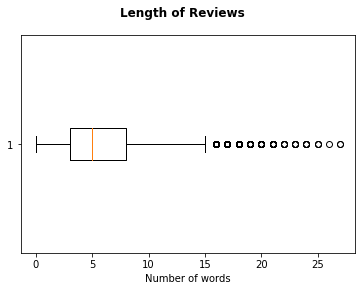

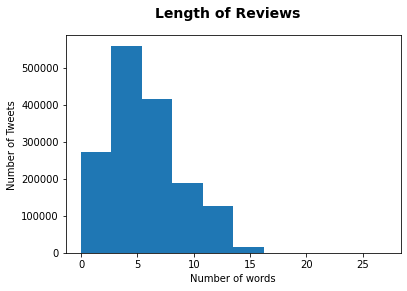

In [92]:
#Creating a box plot for length of reviews
fig = plt.figure(1)
fig.suptitle('Length of Reviews', fontsize=12, fontweight='bold')
ax = fig.add_subplot(111)
ax.boxplot(word_length,vert=False)
ax.set_xlabel('Number of words')

#Creating a histogram for length of reviews
fig = plt.figure(2)
fig.suptitle('Length of Reviews', fontsize=14, fontweight='bold')
bx = fig.add_subplot(111)
bx.hist(word_length)
bx.set_xlabel('Number of words')
bx.set_ylabel('Number of Tweets')
plt.show()

In [93]:
# remove tokens with word length less than 3 and more than 15
df_twitter_final = df_twitter_lw_fix[(word_length>3) & (word_length<16)].copy()
df_twitter_final.reset_index(drop=True, inplace=True)

In [94]:
len(df_twitter_lw_fix) - len(df_twitter_final)

468067

#### 5.5.6. Retokenization

In [95]:
tknzr = TweetTokenizer()

reviews_2 = df_twitter_final['reviews'].tolist()
sentiments_2 = df_twitter_final['labels'].tolist()

reviews_2 = [tknzr.tokenize(s) for s in reviews_2]

#### 5.5.7. Stop word removal and lemmatization

In [96]:
stop_words = stopwords.words('english')+["rt", 'u',"im", "r", "re", "ur"]

# Some stop words might indicate a certain sentiment and hence we are exculing them them
non_sw = ["not", "no"]

tweets_1=[]
for tokens in reviews_2:
  sentence = [w for w in tokens if (w not in stop_words) or (w in non_sw)]
  tweets_1.append(sentence)

lemmatizer = WordNetLemmatizer()
tweets_2 = []
for tokens in tweets_1:
    sentence = [lemmatizer.lemmatize(w) for w in tokens ]
    tweets_2.append(sentence)

#### 5.5.8. Final preprocessed and clean dataset to be used in our models

In [97]:
d = {'labels': sentiments_2, 'reviews': reviews_2}
final_data = pd.DataFrame(d)
final_data.head()

,labels,reviews
0,0,"[cool, tweet, apps, razr]"
1,0,"[know, family, drama, lame, next, time, hang, like, sleepover, whatever, call]"
2,0,"[school, email, open, geography, stuff, revise, stupid, school]"
3,0,"[going, miss, pastor, sermon, faith]"
4,0,"[gahh, peyton, need, live, horrible]"


In [98]:
final_data['reviews'] = [' '.join(map(str, l)) for l in final_data['reviews']]
final_data.to_csv(path_dir + 'output/preprocessed_data.csv', index=False, header=False)
final_data.head()

,labels,reviews
0,0,cool tweet apps razr
1,0,know family drama lame next time hang like sleepover whatever call
2,0,school email open geography stuff revise stupid school
3,0,going miss pastor sermon faith
4,0,gahh peyton need live horrible


In [99]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1111382 entries, 0 to 1111381
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   labels   1111382 non-null  int64 
 1   reviews  1111382 non-null  object
dtypes: int64(1), object(1)
memory usage: 17.0+ MB


## <a name="s6">6. EDA</a>

In [100]:
final_data = pd.read_csv(path_dir + 'output/preprocessed_data.csv', names=['labels', 'reviews'])

### <a name="s6-1">6.1. Word Length Distribution</a>

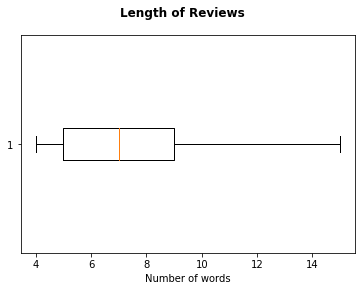

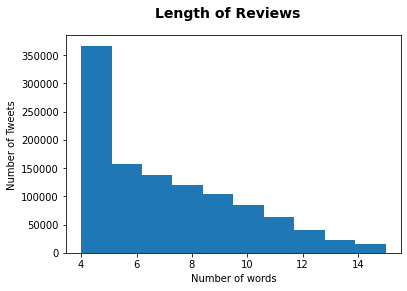


Maximum number of words in reviews : 15


In [101]:
word_len = final_data['reviews'].str.split().str.len()
#Creating a box plot for length of reviews
fig = plt.figure(1)
fig.suptitle('Length of Reviews', fontsize=12, fontweight='bold')
ax = fig.add_subplot(111)
ax.boxplot(word_len,vert=False)
ax.set_xlabel('Number of words')

#Creating a histogram for length of reviews
fig = plt.figure(2)
fig.suptitle('Length of Reviews', fontsize=14, fontweight='bold')
bx = fig.add_subplot(111)
bx.hist(word_len)
bx.set_xlabel('Number of words')
bx.set_ylabel('Number of Tweets')


plt.show()
print("\nMaximum number of words in reviews :",max(word_len))

### <a name="s6-2">6.2. Word Cloud</a>

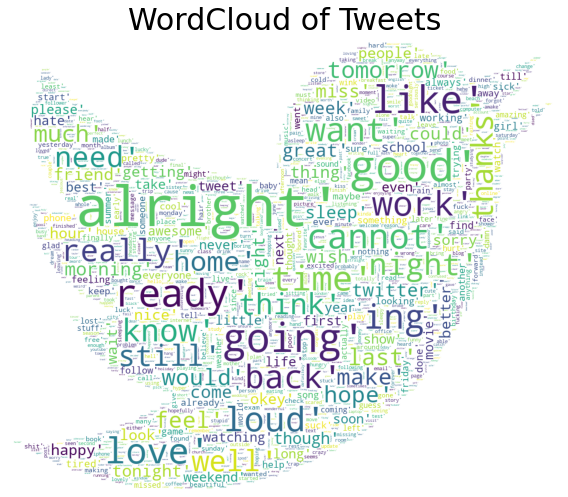

In [102]:
all_words = [word for line in final_data.reviews for word in line.split()] # split text
def plot_wordcloud(text, mask=None, max_words=25000, max_font_size=100, figure_size=(8.0,8.0), color = 'white',
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)

    wordcloud = WordCloud(background_color=color,
                    stopwords=stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=400, 
                    height=200,
                    mask = mask,
                    collocations = False)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask)
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud)
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off')
    plt.tight_layout()  

pos_mask = np.array(Image.open(path_dir + 'data/twitter.png'))
plot_wordcloud(all_words,mask=pos_mask,color='white',max_font_size=100,title_size=30,title="WordCloud of Tweets")

In [103]:
final_data.to_csv(path_dir + 'output/preprocessed_data_final.csv', index=False, header=False)